In [31]:
import numpy as np
from kneed import KneeLocator
import nltk 
from nltk.tokenize import TreebankWordTokenizer
from gensim.models import Word2Vec
import math
import pyonmttok
from sklearn.neighbors import NearestNeighbors
import daal4py
import re
import time
import logging
from statistics import mean, stdev
import matplotlib.pyplot as plt
import multiprocessing
from statistics import mean, stdev
from fuzzywuzzy import fuzz
import pandas as pd

/anaconda3/envs/inteldaal/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
def reader(fname):
    """
    Currently reader is implemented just as a reader from file
    :param fname:
    :return:
    """
    with open('errors.log') as my_file:
        errors = my_file.readlines()
    return list(map(lambda x: x.rstrip(), errors))

In [3]:
def remove_whitespaces(sentence):
    """
    Some error messages has multiple spaces, so we change it to one space.
    :param sentence:
    :return:
    """
    return " ".join(sentence.split())

In [4]:
def clear_strings(data):
    """
    Clear error messages from unnecessary data:
    - UID/UUID in file paths
    - line numbers - as an example "error at line number ..."
    Removed parts of text are substituted with titles
    :param data:
    :return:
    """
    _uid = r'[0-9a-zA-Z]{12,128}'
    _line_number = r'(at line[:]*\s*\d+)'
    _uuid = r'[a-f0-9]{8}-[a-f0-9]{4}-4[a-f0-9]{3}-[89aAbB][a-f0-9]{3}-[a-f0-9]{12}'

    for idx, item in enumerate(data):
        _cleaned = re.sub(_line_number, "at line LINE_NUMBER", item)
        _cleaned = re.sub(_uid, "UID", _cleaned)
        _cleaned = re.sub(_uuid, "UUID", _cleaned)
        data[idx] = remove_whitespaces(_cleaned)

In [5]:
def tokenization(errors):
    """
    Tokenization of a list of error messages.
    The best tokenizer for error messages is TreebankWordTokenizer (nltk).
    It's good at tokenizing file paths.
    :param errors:
    :return:
    """
    tokenized = []
    for line in errors:
        tokenized.append(TreebankWordTokenizer().tokenize(line))
    return tokenized

In [6]:
def pyonmttok_tokenization(data):
    """
    Alternative tokenizer. It performs much faster, but worse in tokenizing of paths.
    It splits all paths by "/".
    TODO: This method should be optimized to the same tokenization quality as TreebankWordTokenizer
    :param data:
    :return:
    """
    pyonmttok_tokens = []
    tokenizer = pyonmttok.Tokenizer("space", joiner_annotate=False, segment_numbers=False)
    for doc in data:
        tokens, features = tokenizer.tokenize(doc)
        pyonmttok_tokens.append(tokens)
    return pyonmttok_tokens

In [52]:
def train_word2vec(sentences, size=100, window=10, min_count=1, workers=4, iter=10):
    """
    Training word2vec model
    :param sentences: tokenized sentences
    :param size: size of the vector to represent each token
    :param window: max distance between target token and its neighbors
    :param min_count: minimium frequency count of words
    :param workers: number of CPUs
    :param iter:
    :return:
    """
    return Word2Vec(sentences, size=size, window=window, min_count=min_count, workers=workers, iter=iter)


In [8]:
def sentence2vec(sentences, model):
    """
    Calculates mathematical average of the word vector representations
    of all the words in each sentence
    :param sentences: tokenized
    :param model: word2vec model
    :return:
    """
    X=[]
    for sent in sentences:
        sent_vec =[]
        numw = 0
        for w in sent:
            try:
                if numw == 0:
                    sent_vec = model[w]
                else:
                    sent_vec = np.add(sent_vec, model[w])
                numw+=1
            except:
                pass

        X.append(np.asarray(sent_vec) / numw)
    return np.array(X)

In [9]:
def kneighbors(X):
    """
    Calculates average distances for k-nearest neighbors
    :param X:
    :return:
    """
    k = round(math.sqrt(len(X)))
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    if k > 2:
        avg_distances = []
        for line in distances:
            avg_distances.append(mean(line))
        return avg_distances
    else:
        return distances[:,1]

In [10]:
def epsilon_search(distances):
    """
    Search epsilon for DBSCAN
    :param distances:
    :return:
    """
    kneedle = KneeLocator(distances, list(range(len(distances))))
    return max(kneedle.all_elbows)

In [49]:
def distance_curve(distances):
    """
    Save distance curve with knee candidates in file.
    :param distances:
    :return:
    """
    sensitivity = [1, 3, 5, 10, 100, 150, 200]
    knees = []
    y = list(range(len(distances)))
    for s in sensitivity:
        kl = KneeLocator(distances, y, S=s)
        knees.append(kl.knee)

    plt.style.use('ggplot');
    plt.figure(figsize=(10, 10))
    plt.plot(distances, y)
    colors = ['r', 'g', 'k', 'm', 'c', 'b', 'y']
    for k, c, s in zip(knees, colors, sensitivity):
        plt.vlines(k, 0, len(distances), linestyles='--', colors=c, label=f'S = {s}')
    plt.legend()
    plt.show()
    print(knees)

In [80]:
def dbscan(X, epsilon, min_samples):
    """
    DBSCAN clusteing with daal4py library
    :param X:
    :param epsilon:
    :return: DBSCAN labels
    """
    algo = daal4py.dbscan(minObservations=min_samples, epsilon=epsilon,
                          resultsToCompute='computeCoreIndices|computeCoreObservations')
    result = algo.compute(X)
    return result.assignments[:, 0]


In [13]:
errors = reader('errors.log')

In [15]:
errors

['Fatal error in athena logfile: "Logfile error in log.SUSY16Merge: "ToolSvc.UID FATAL Failed to call UID()""',
 'Fatal error in athena logfile: "Logfile error in log.UID: "ToolSvc.UID FATAL Failed to call UID()""',
 'Missing AthenaMP outputs file athenaMP-outputs-EVNTtoHITS-sim (probably athena crashed)',
 'LRMS error: (91) Job failed',
 'OK',
 'Fatal error in athena logfile: "Logfile error in log.EXOT12Merge: "ToolSvc.UID FATAL Failed to call UID()""',
 'Non-zero return code from RAWtoESD (65); Logfile error in log.RAWtoESD: "StreamESD FATAL UID failed."',
 'EVNTtoHITS got a SIGIOT signal (exit code 134); Logfile error in log.EVNTtoHITS: "PoolSvc FATAL in UID(): standard std::exception is caught"',
 'Fatal error in athena logfile: "Logfile error in log.SUSY4Merge: "ToolSvc.UID FATAL Failed to call UID()""',
 'Non-zero return code from OverlayPool (2); Logfile error in log.OverlayPool: "UID: include file NULL can not be found"',
 'FTAG2Merge got a SIGSEGV signal (exit code 139); Logfi

In [14]:
clear_strings(errors)

In [16]:
tokenized = tokenization(errors)

In [17]:
tokenized

[['Fatal',
  'error',
  'in',
  'athena',
  'logfile',
  ':',
  '``',
  'Logfile',
  'error',
  'in',
  'log.SUSY16Merge',
  ':',
  '``',
  'ToolSvc.UID',
  'FATAL',
  'Failed',
  'to',
  'call',
  'UID',
  '(',
  ')',
  "''",
  "''"],
 ['Fatal',
  'error',
  'in',
  'athena',
  'logfile',
  ':',
  '``',
  'Logfile',
  'error',
  'in',
  'log.UID',
  ':',
  '``',
  'ToolSvc.UID',
  'FATAL',
  'Failed',
  'to',
  'call',
  'UID',
  '(',
  ')',
  "''",
  "''"],
 ['Missing',
  'AthenaMP',
  'outputs',
  'file',
  'athenaMP-outputs-EVNTtoHITS-sim',
  '(',
  'probably',
  'athena',
  'crashed',
  ')'],
 ['LRMS', 'error', ':', '(', '91', ')', 'Job', 'failed'],
 ['OK'],
 ['Fatal',
  'error',
  'in',
  'athena',
  'logfile',
  ':',
  '``',
  'Logfile',
  'error',
  'in',
  'log.EXOT12Merge',
  ':',
  '``',
  'ToolSvc.UID',
  'FATAL',
  'Failed',
  'to',
  'call',
  'UID',
  '(',
  ')',
  "''",
  "''"],
 ['Non-zero',
  'return',
  'code',
  'from',
  'RAWtoESD',
  '(',
  '65',
  ')',
  ';',
  '

In [53]:
_word2vec = train_word2vec(tokenized)

In [54]:
_word2vec.__dict__

{'max_final_vocab': None,
 'callbacks': (),
 'load': <function gensim.utils.call_on_class_only(*args, **kwargs)>,
 'wv': <gensim.models.keyedvectors.Word2VecKeyedVectors at 0x3a3dff29e8>,
 'vocabulary': <gensim.models.word2vec.Word2VecVocab at 0x3a3dff2940>,
 'trainables': <gensim.models.word2vec.Word2VecTrainables at 0x3a3dff2dd8>,
 'sg': 0,
 'alpha': 0.025,
 'window': 10,
 'random': RandomState(MT19937) at 0x3A3C080A98,
 'min_alpha': 0.0001,
 'hs': 0,
 'negative': 5,
 'ns_exponent': 0.75,
 'cbow_mean': 1,
 'compute_loss': False,
 'running_training_loss': 0.0,
 'min_alpha_yet_reached': 0.00012533157498115927,
 'corpus_count': 5308,
 'corpus_total_words': 191409,
 'vector_size': 100,
 'workers': 4,
 'epochs': 10,
 'train_count': 1,
 'total_train_time': 0.5844701001187786,
 'batch_words': 10000,
 'model_trimmed_post_training': False}

In [55]:
_word2vec.wv.__dict__

{'vectors': array([[ 1.9596556e+00,  2.5818804e-01,  1.2920451e+00, ...,
          2.4107060e+00,  3.9446837e-01,  1.1706085e+00],
        [ 1.0384787e+00, -1.8251762e+00,  6.1571550e-01, ...,
          1.1098577e+00,  1.1243899e+00, -1.5099937e+00],
        [-1.0910307e+00,  5.8305573e-01,  1.0908731e+00, ...,
          1.2825726e+00, -6.1109066e-01,  1.5394062e+00],
        ...,
        [ 4.6596017e-02,  2.2209285e-02,  2.0880066e-02, ...,
          4.5513138e-02, -8.1336182e-03,  4.5142088e-02],
        [ 1.4029390e-02,  2.5102913e-02, -1.0625227e-02, ...,
          3.4270283e-02, -3.3925068e-02,  1.5469863e-02],
        [ 2.3918929e-02,  1.2336757e-02, -6.4493646e-04, ...,
          2.7409339e-02, -1.7470276e-02,  2.1256451e-02]], dtype=float32),
 'vocab': {'Fatal': <gensim.models.keyedvectors.Vocab at 0x3a3bda8b00>,
  'error': <gensim.models.keyedvectors.Vocab at 0x3a3dfd3ac8>,
  'in': <gensim.models.keyedvectors.Vocab at 0x3a3dff2780>,
  'athena': <gensim.models.keyedvectors.Voca

In [56]:
_sent2vec = sentence2vec(tokenized, _word2vec)

/anaconda3/envs/inteldaal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
/anaconda3/envs/inteldaal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [57]:
_sent2vec

array([[ 0.01934334, -0.4349777 ,  1.3290379 , ...,  0.44443107,
         1.2627317 ,  0.5807182 ],
       [-0.04801069, -0.44205976,  1.3972584 , ...,  0.47076997,
         1.2906815 ,  0.6477568 ],
       [-0.34540495, -0.28366032,  0.5982102 , ...,  0.24823332,
         1.032163  ,  0.2508226 ],
       ...,
       [-0.997752  , -1.3150997 ,  1.6106714 , ..., -0.856496  ,
         1.8479671 , -0.29404768],
       [-0.89144605,  0.78376895,  1.4076821 , ...,  1.4540421 ,
         0.10202614,  1.133005  ],
       [-1.557733  , -1.1811663 ,  1.9034994 , ..., -0.59242696,
         1.5490522 ,  0.7212243 ]], dtype=float32)

In [58]:
distances = kneighbors(_sent2vec)

In [59]:
distances

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

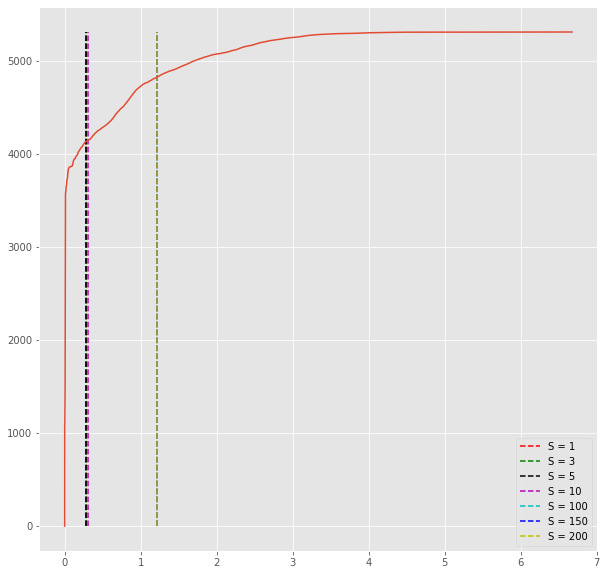

[0.28361371045007955, 0.28361371045007955, 0.28361371045007955, 0.3079233817525752, 1.2186066517696748, 1.2186066517696748, 1.2186066517696748]


In [60]:
knees = distance_curve(distances)

In [61]:
epsilon = epsilon_search(distances)

In [62]:
epsilon

1.2186066517696748

In [81]:
cluster_labels = dbscan(_sent2vec, epsilon, 1)

In [82]:
cluster_labels

array([ 0,  0,  1, ..., 15,  6, 11], dtype=int32)

In [83]:
def print_clusters(ds, labels):
    results = {}
    for label in set(labels):
        elements = []
        for idx, l in enumerate(labels):
            if l == label:
                elements.append(ds[idx])
        results[label] = elements
    return results

In [27]:
def print_cluster(data, labels, cluster_label):
    results = []
    for idx, l in enumerate(labels):
        if l == cluster_label:
            results.append(data[idx])
    return results

In [28]:
def cluster_stats(cluster_results):
    clusters = []
    for item in cluster_results:
        cluster = {}
        cluster["cluster_name"] = item
        cluster["first_entry"] = cluster_results[item][0]
        cluster["cluster_size"] = len(cluster_results[item])
        lengths = []
        for s in cluster_results[item]:
            lengths.append(len(s))
        mean_length = mean(lengths)
        try:
            std_length = stdev(lengths)
        except:
            std_length = 0
        cluster["mean_length"] = mean_length
        cluster["std_lengt"] = std_length
        dist = []
        x0 = cluster_results[item][0]
        for i in range(0,len(cluster_results[item])):
            x = cluster_results[item][i]
            dist.append(fuzz.ratio(x0,x))
        cluster["mean_similarity"] = mean(dist)
        try:
            cluster["std_similarity"] = stdev(dist)
        except:
            cluster["std_similarity"] = 0
        clusters.append(cluster)
    clusters_df = pd.DataFrame(clusters)
    return clusters_df.sort_values(by=['mean_similarity'])

In [84]:
clustered_errors = print_clusters(errors, cluster_labels)

In [85]:
df = cluster_stats(clustered_errors)

In [86]:
df

,cluster_name,first_entry,cluster_size,mean_length,std_lengt,mean_similarity,std_similarity
16,16,Non-zero return code from HITtoRDO (65); Logfi...,104,206.086538,25.259857,58.625000,16.328061
4,4,Non-zero return code from RAWtoESD (65); Logfi...,357,130.184874,28.327925,65.386555,9.868042
5,5,EVNTtoHITS got a SIGIOT signal (exit code 134)...,48,136.791667,20.359491,65.916667,12.361287
13,13,File myHIST.root did not pass corruption test,406,71.933498,12.497230,70.219212,8.540606
34,34,Failed in data staging: Failed checking source...,30,331.800000,29.363829,70.933333,30.691944
52,52,LRMS error: (271) ; Failed in data staging: Fa...,1763,459.389109,15.049767,71.018151,3.856641
6,6,FTAG2Merge got a SIGSEGV signal (exit code 139...,734,186.073569,10.959931,72.182561,10.227663
14,14,"Fatal error in athena logfile: ""Logfile error ...",7,213.000000,41.456805,73.571429,18.698103
26,26,Failed in data staging: Failed to prepare dest...,98,440.663265,36.214978,75.020408,12.451953
18,18,Failed in data staging: Failed to prepare dest...,122,441.409836,46.480380,75.426230,6.834427


In [87]:
print_cluster(errors, cluster_labels, 16)

['Non-zero return code from HITtoRDO (65); Logfile error in log.HITtoRDO: "SysError in <TFile::ReadBuffer>: error reading from file /cvmfs/atlas-condb.cern.ch/repo/conditions/cond09/cond09_mc.000009.gen.COND/cond09_mc.000009.gen.COND._0011.pool.r (truncated)',
 'Non-zero return code from AODMerge (65); Logfile error in log.AODMerge: "SysError in <TFile::WriteBuffer>: error writing to file AOD.12911580._000063.pool.root.1 (-1) (No space left on device)"',
 'Non-zero return code from AODtoDAOD (65); Logfile error in log.AODtoDAOD: "SysError in <TFile::WriteBuffer>: error writing to file DAOD_EGAM7.DAOD.root (-1) (No space left on device)"',
 'Non-zero return code from HITtoRDO (65); Logfile error in log.HITtoRDO: "SysError in <TFile::WriteBuffer>: error writing to file tmp.RDO_000 (-1) (No space left on device)"',
 'Non-zero return code from AODMerge (65); Logfile error in log.AODMerge: "SysError in <TFile::WriteBuffer>: error writing to file AOD.12908479._003586.pool.root.1 (-1) (Input/